# AIoT Project

In [1]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

#mine
from sklearn.preprocessing import LabelEncoder


%load_ext autoreload
%autoreload 2

Start time of execution

In [2]:
time_start = time()

## Load configuration

In [3]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
client = pymongo.MongoClient(config["client"])

In [5]:
db = client[config["db"]]
coll = db[config["col"]]

In [6]:
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['class_A', 'class_D', 'class_L', 'class_M', 'class_U']


## Load data

Saving CSVs: 0it [00:00, ?it/s]

Saved class_A.csv successfully.
Saved class_D.csv successfully.
Saved class_L.csv successfully.
Saved class_M.csv successfully.
Saved class_U.csv successfully.
Saved class_A.csv successfully.
Saved class_D.csv successfully.
Saved class_L.csv successfully.
Saved class_M.csv successfully.
Saved class_U.csv successfully.
Saved class_A.csv successfully.
Saved class_D.csv successfully.
Saved class_L.csv successfully.
Saved class_M.csv successfully.
Saved class_U.csv successfully.
Saved class_A.csv successfully.
Saved class_D.csv successfully.
Saved class_L.csv successfully.
Saved class_M.csv successfully.
Saved class_U.csv successfully.
All classes exported to CSV.


Counting instances:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\kmats\AppData\Local\Temp\ipykernel_2592\1724931578.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=csv_files, y=file_counts, palette='viridis')


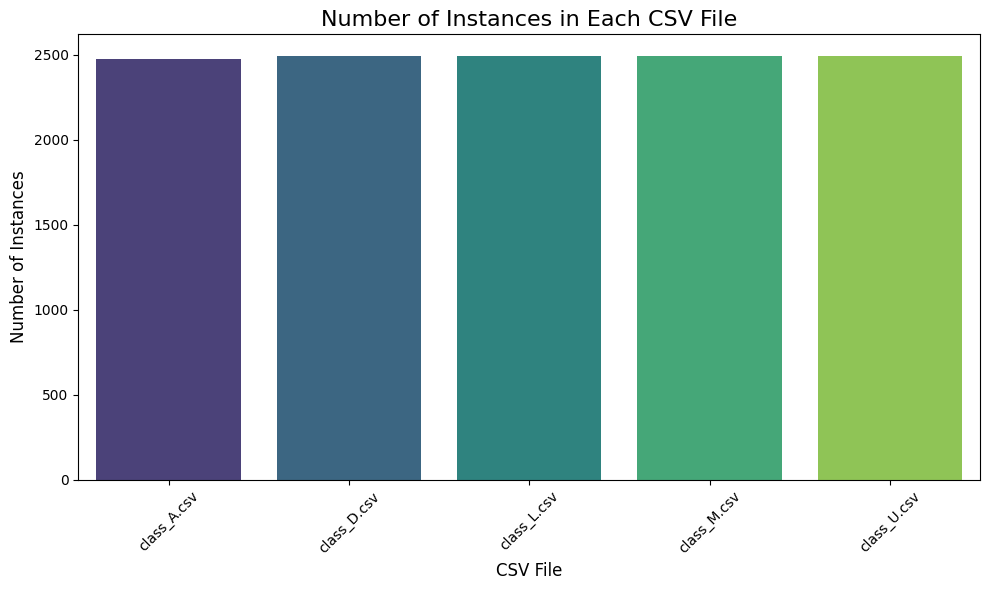

In [7]:
save_path = "loaded_data"

# Create folder if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Get documents from database 
documents = coll.find()

# Use tqdm for progress bar when saving CSVs
for doc in tqdm(documents, desc="Saving CSVs"):
    label = doc["label"]  
    data = doc["data"]

    # Dataframe of the watch data
    df = pd.DataFrame({
        "acc_x": data["acc_x"],
        "acc_y": data["acc_y"],
        "acc_z": data["acc_z"],
    })

    # filename for each collection
    filename = f"{label}.csv"
    file_path = os.path.join(save_path, filename)

    # save DataFrame to CSV
    df.to_csv(file_path, index=False)

    print(f"Saved {filename} successfully.")

print("All classes exported to CSV.")

# print bar graphs for each csv file 
csv_folder = "loaded_data"
csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

# list for storing the number of instances in each CSV file
file_counts = []

# Use tqdm for progress bar when counting instances
for csv_file in tqdm(csv_files, desc="Counting instances"):
    file_path = os.path.join(csv_folder, csv_file)
    df = pd.read_csv(file_path)
    file_counts.append(len(df)) 

# barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=csv_files, y=file_counts, palette='viridis')

# title and labels
plt.title('Number of Instances in Each CSV File', fontsize=16)
plt.xlabel('CSV File', fontsize=12)
plt.ylabel('Number of Instances', fontsize=12)

plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

As it seems, all classes have approximately 2500 instances.

Processing class_A.csv...


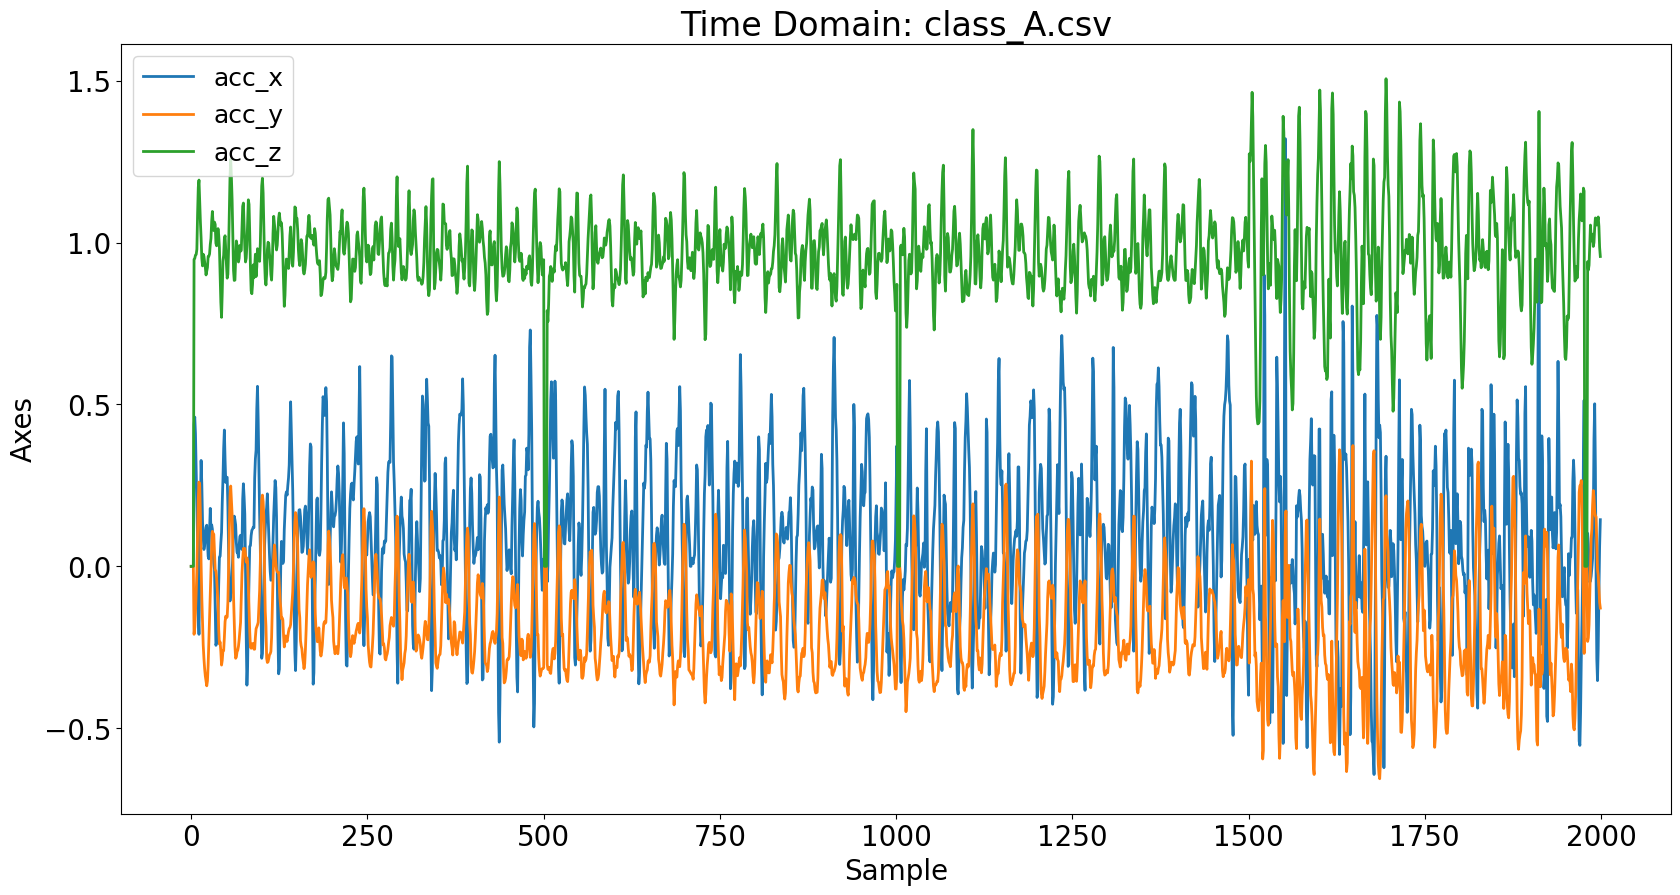

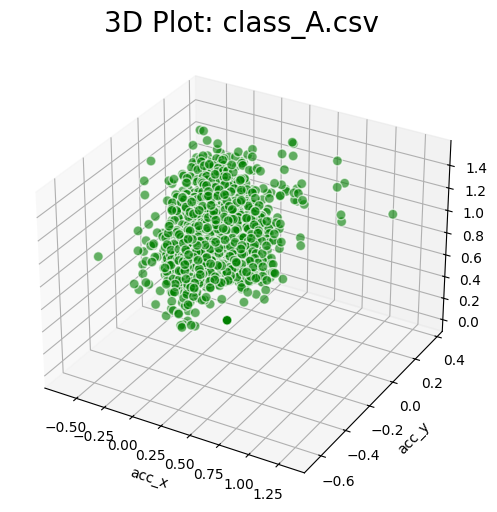

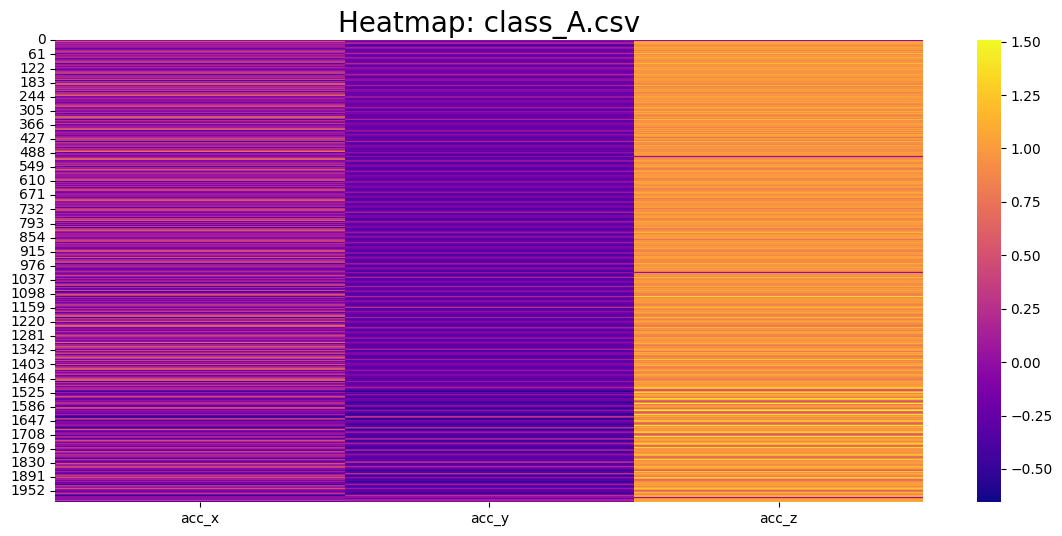

Processing class_D.csv...


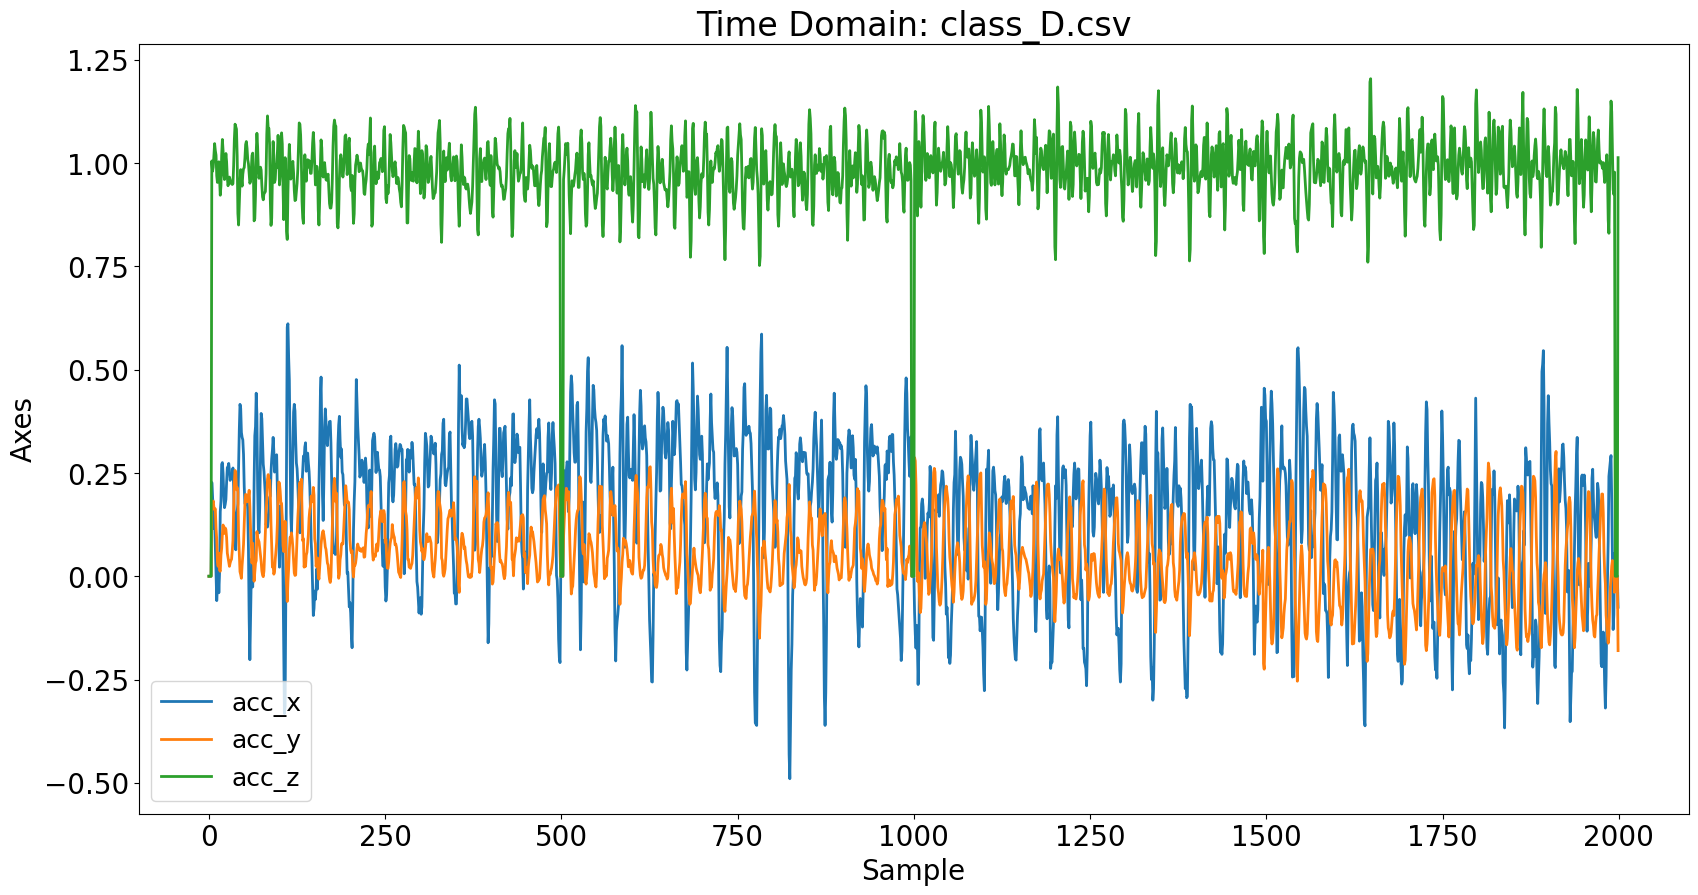

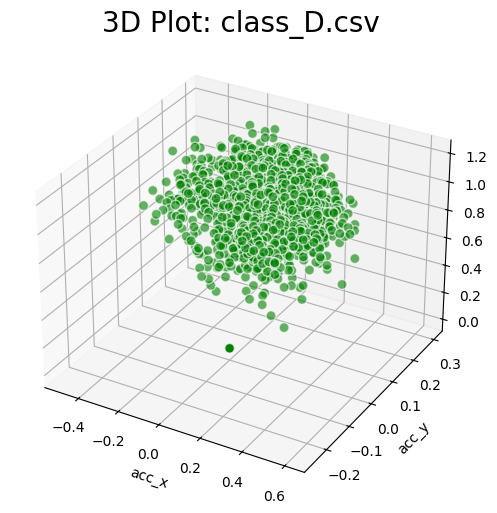

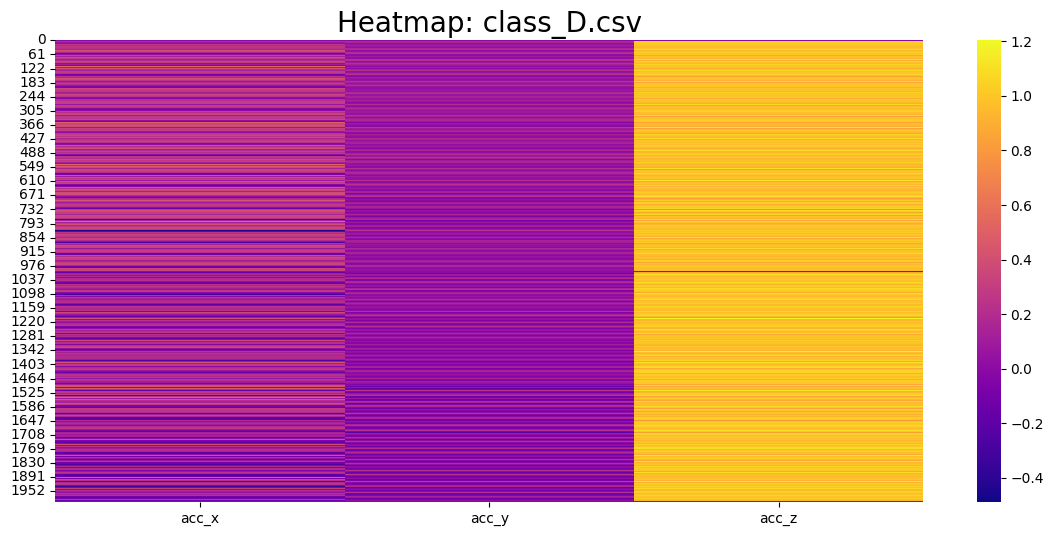

Processing class_L.csv...


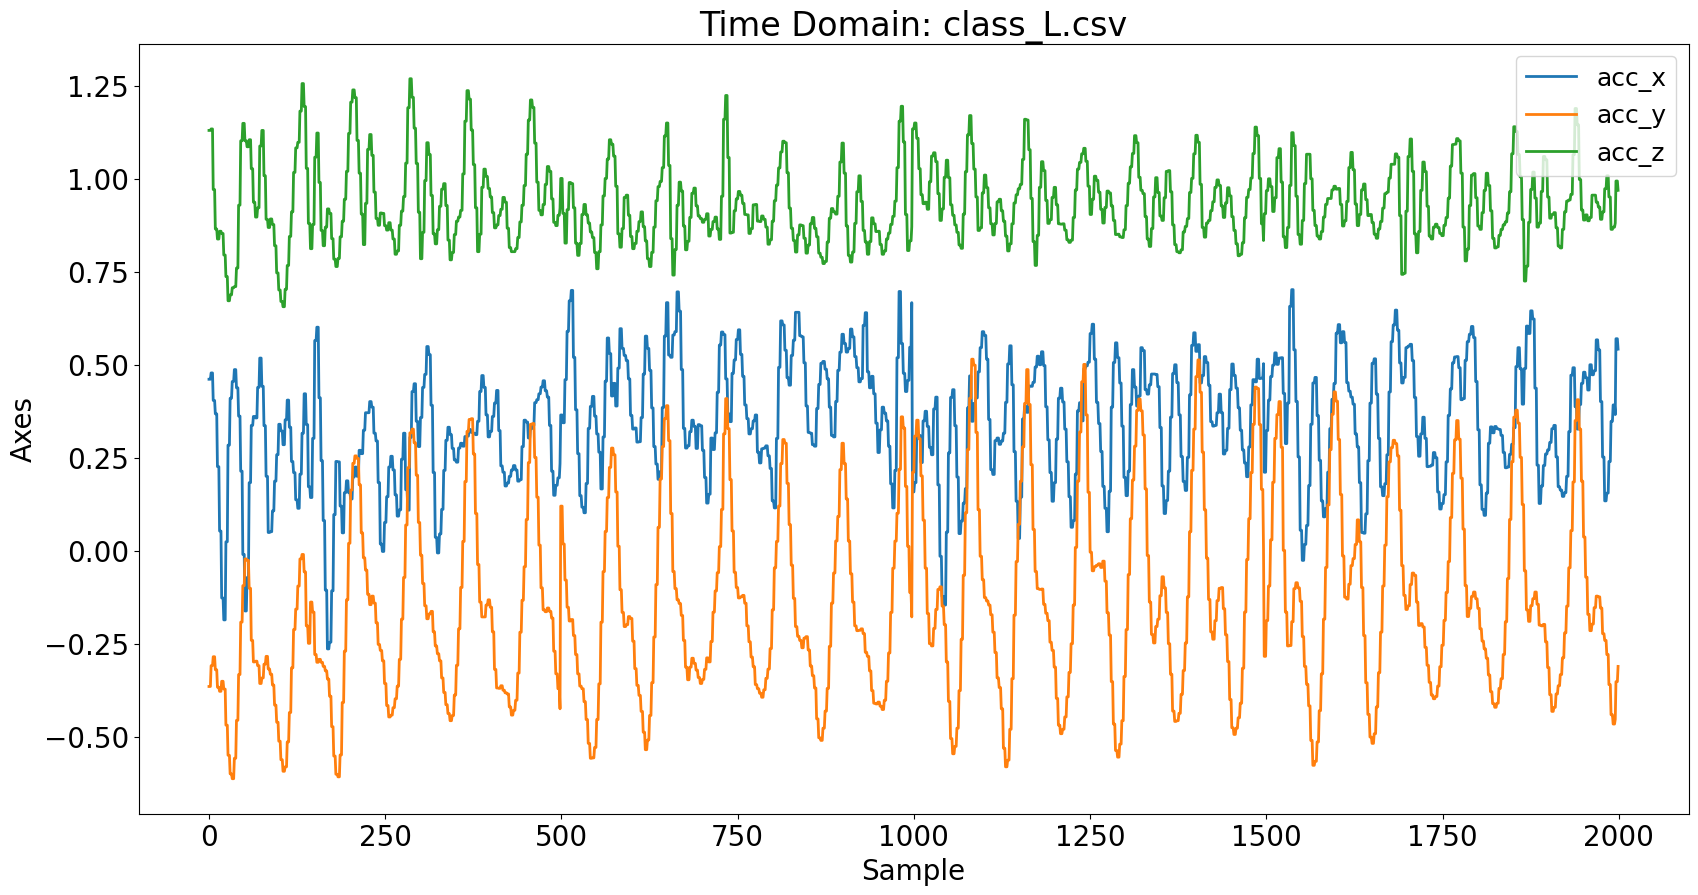

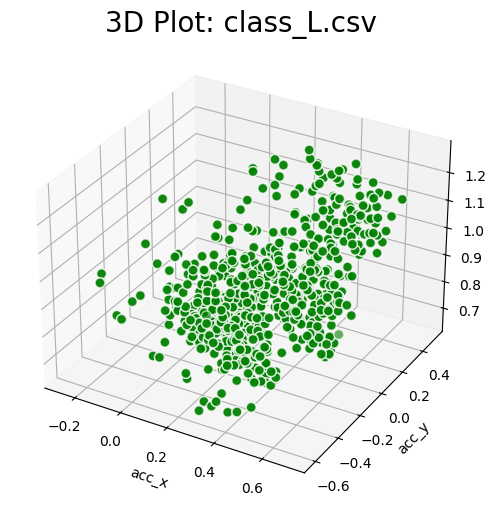

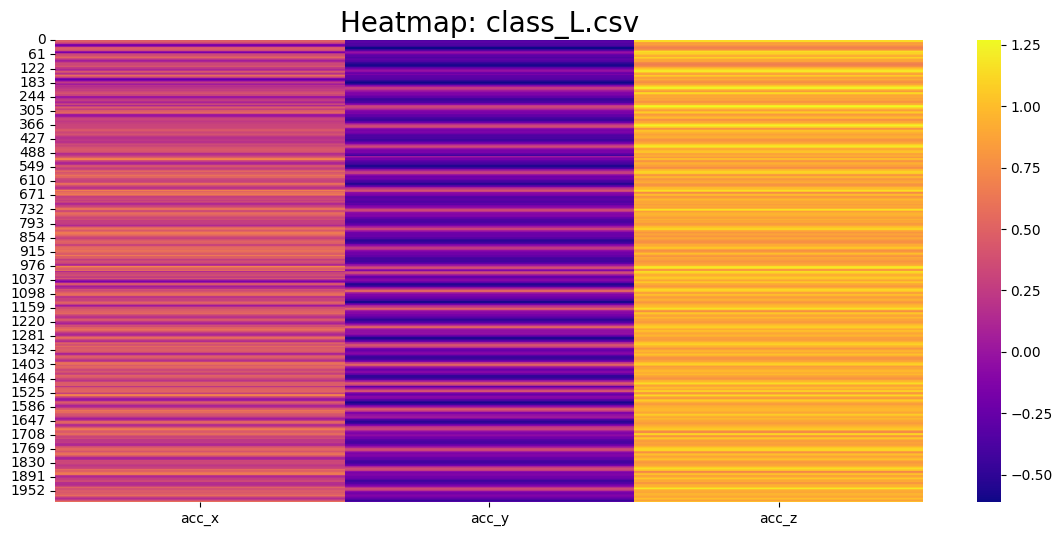

Processing class_M.csv...


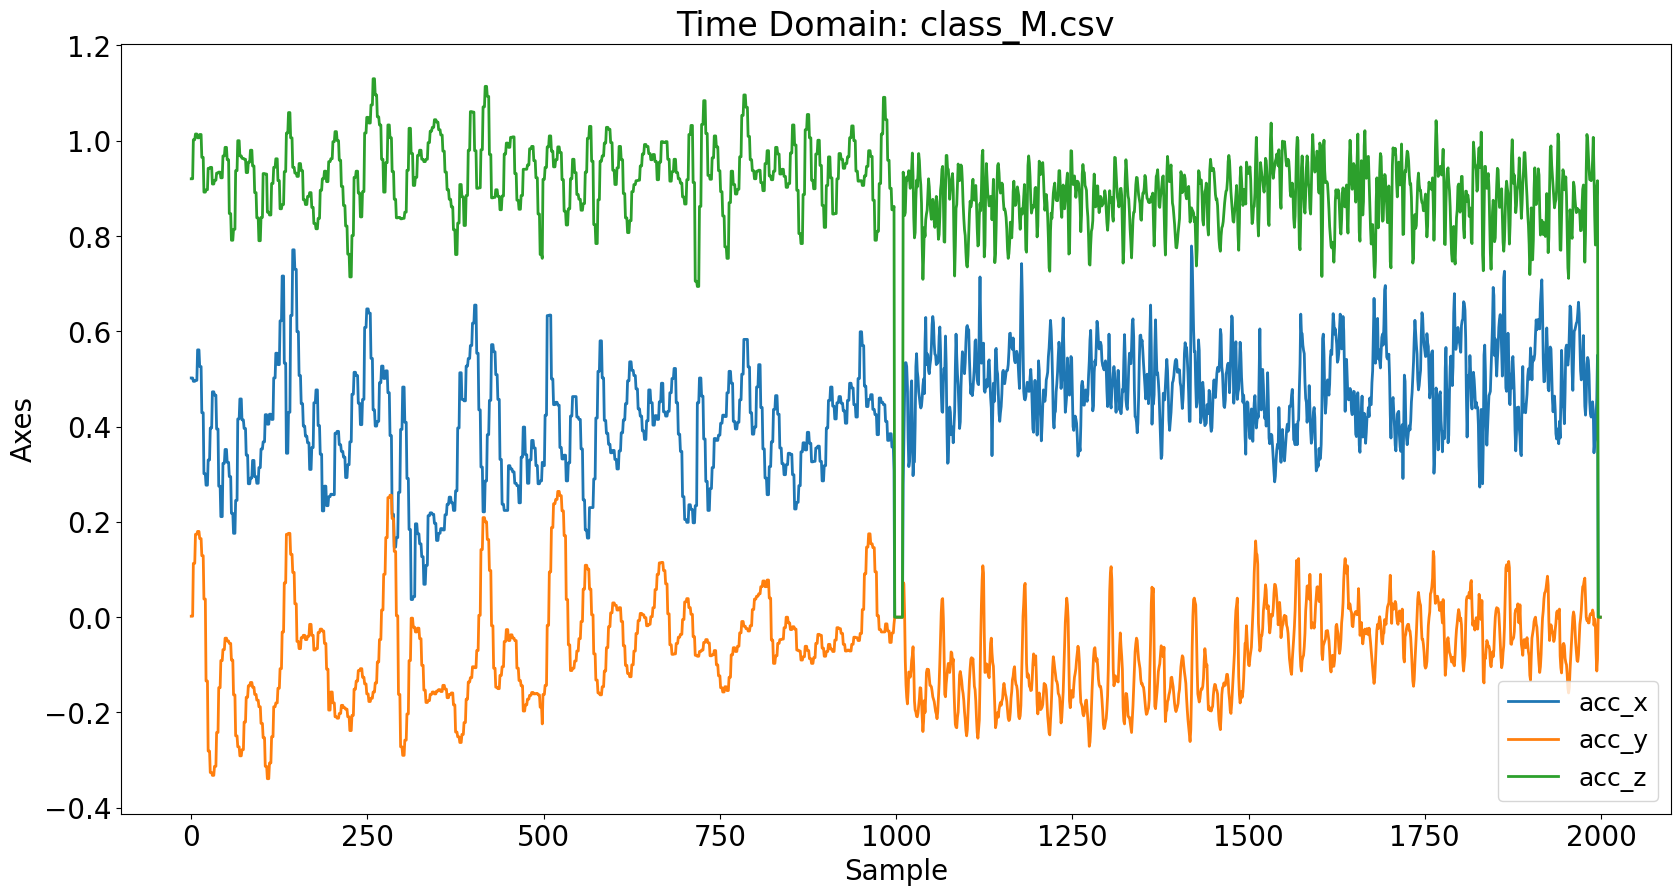

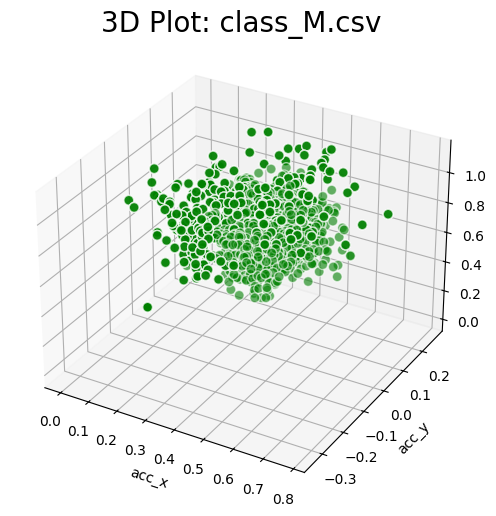

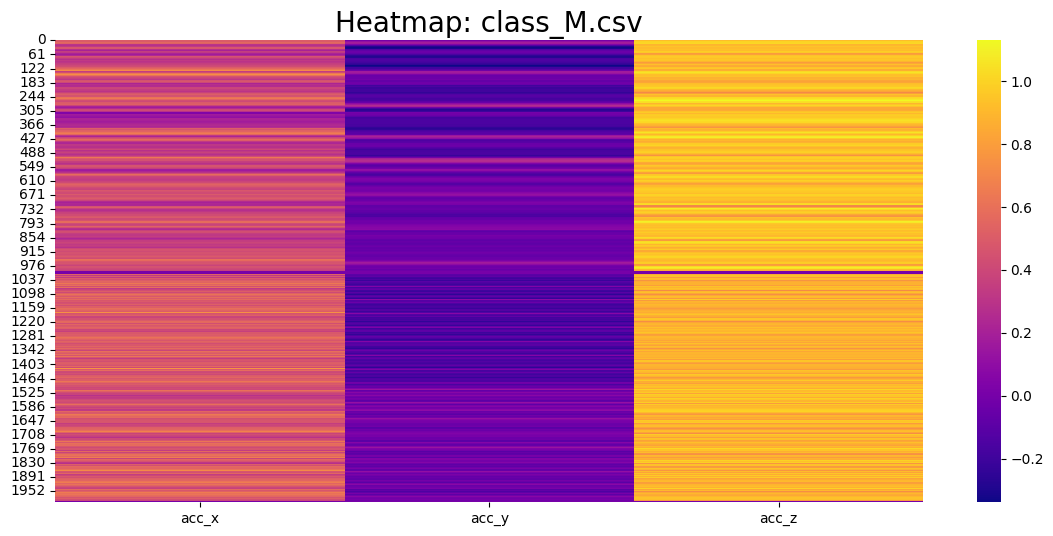

Processing class_U.csv...


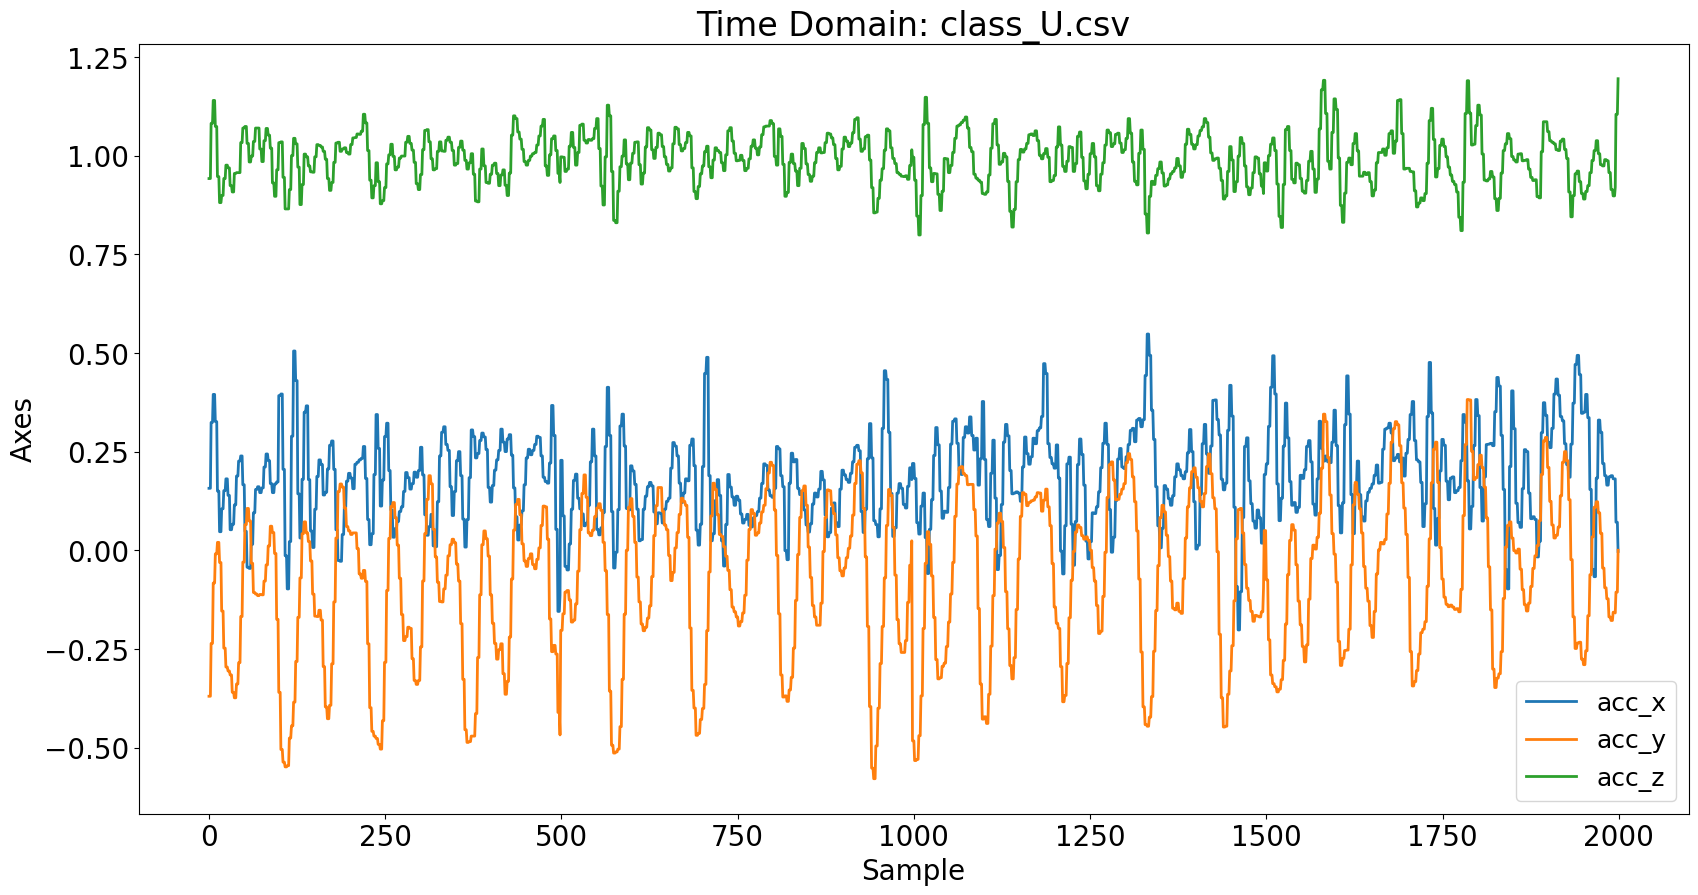

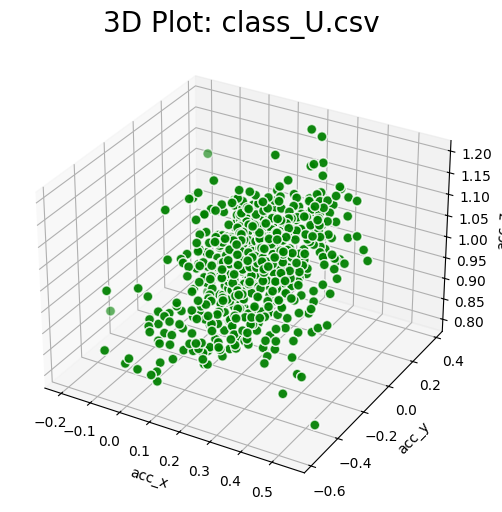

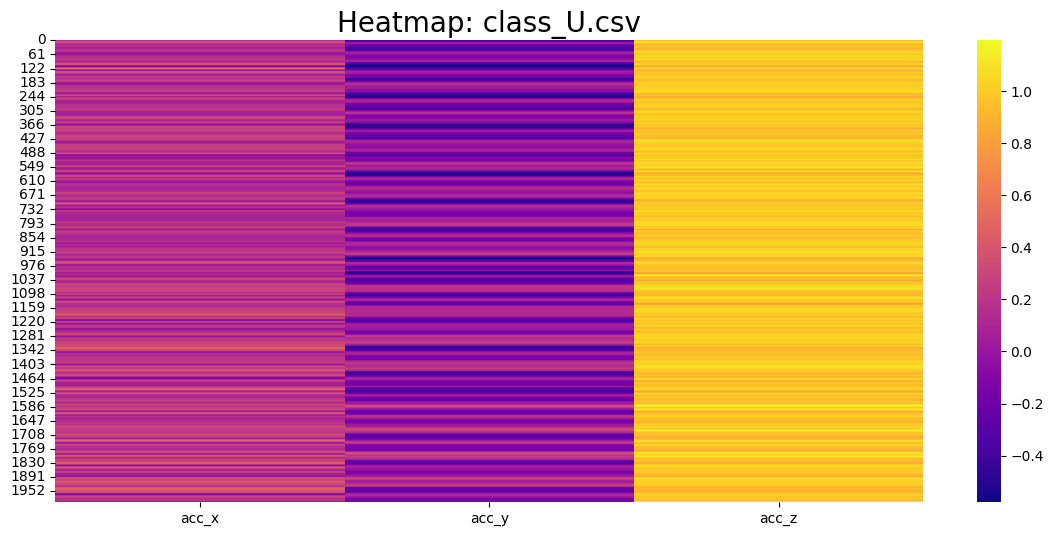

In [8]:
for csv_file in csv_files:
    print(f"Processing {csv_file}...")
    
    # load CSV
    file_path = os.path.join(csv_folder, csv_file)
    df = pd.read_csv(file_path)

    # keep the first 2000
    df = df.head(2000)

    # 1. plot_instance_time_domain
    plot_instance_time_domain(df)
    plt.title(f"Time Domain: {csv_file}", fontsize=24)
    plt.show()

    # 2. plot_instance_3d
    plot_instance_3d(df)
    plt.title(f"3D Plot: {csv_file}", fontsize=20)
    plt.show()

    # 3. plot_heatmap
    plot_heatmap(df)
    plt.title(f"Heatmap: {csv_file}", fontsize=20)
    plt.show()

As we see in the above graphs, there is much higher variance in the z-axis which is expected as in the data collection process, the hand of the wearer moved mainly up and down.

## Explore the nature of the data

In [9]:
# list for the windows of each class
all_windows = {}

# for each csv file, load the data and apply sliding window
for csv_file in tqdm(csv_files, desc="Sliding window on CSVs"):
    file_path = os.path.join(csv_folder, csv_file)
    
    # load the csv file
    df = pd.read_csv(file_path)
    
    # sliding window
    windows = sliding_window_pd(
        df[['acc_x', 'acc_y', 'acc_z']], 
        config["sliding_window"]["ws"], 
        config["sliding_window"]["overlap"], 
        config["sliding_window"]["w_type"], 
        config["sliding_window"]["w_center"], 
        config["sliding_window"]["print_stats"]
        )
    
    # remove the .csv extension
    file_name_no_ext = os.path.splitext(csv_file)[0]
    
    # save the windows in the dictionary
    all_windows[file_name_no_ext] = windows

# length of the windows for each csv file
for file_name, windows in all_windows.items():
    print(f"{file_name}: {len(windows)} windows")

Sliding window on CSVs:   0%|          | 0/5 [00:00<?, ?it/s]

Print Window: 1
Number of samples: 100
Print Window: 2
Number of samples: 100
Print Window: 3
Number of samples: 100
Print Window: 4
Number of samples: 100
Print Window: 5
Number of samples: 100
Print Window: 6
Number of samples: 100
Print Window: 7
Number of samples: 100
Print Window: 8
Number of samples: 100
Print Window: 9
Number of samples: 100
Print Window: 10
Number of samples: 100
Print Window: 11
Number of samples: 100
Print Window: 12
Number of samples: 100
Print Window: 13
Number of samples: 100
Print Window: 14
Number of samples: 100
Print Window: 15
Number of samples: 100
Print Window: 16
Number of samples: 100
Print Window: 17
Number of samples: 100
Print Window: 18
Number of samples: 100
Print Window: 19
Number of samples: 100
Print Window: 20
Number of samples: 100
Print Window: 21
Number of samples: 100
Print Window: 22
Number of samples: 100
Print Window: 23
Number of samples: 100
Print Window: 24
Number of samples: 100
Print Window: 25
Number of samples: 100
Print Win

All classes have 48 windows, each containing 100 samples.

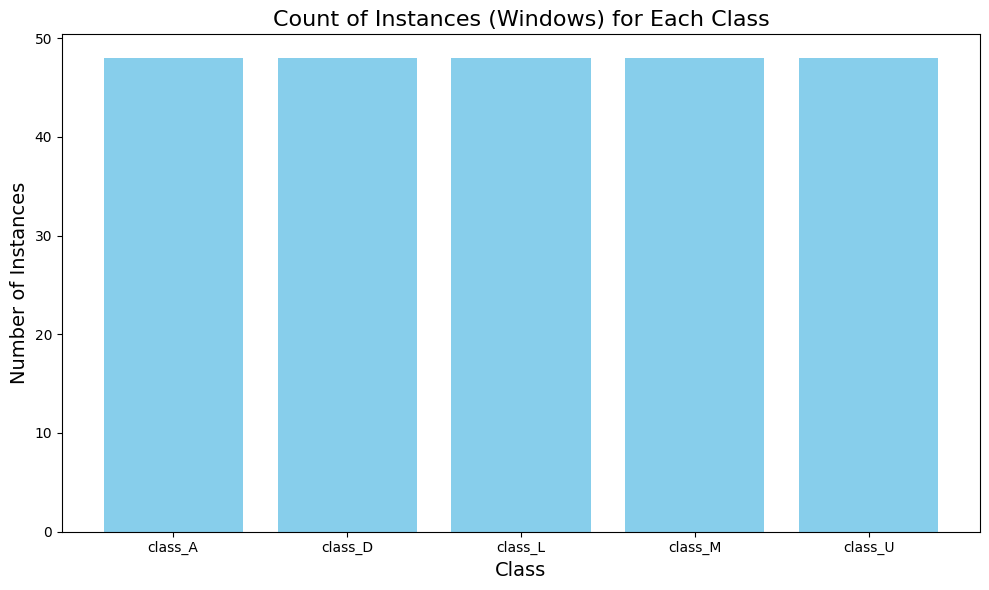

In [10]:
# print number of windows for each class
class_counts = {csv_file: len(windows) for csv_file, windows in all_windows.items()}

# Barplot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# title and labels
plt.title('Count of Instances (Windows) for Each Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)


plt.tight_layout()
plt.show()

## Apply filter

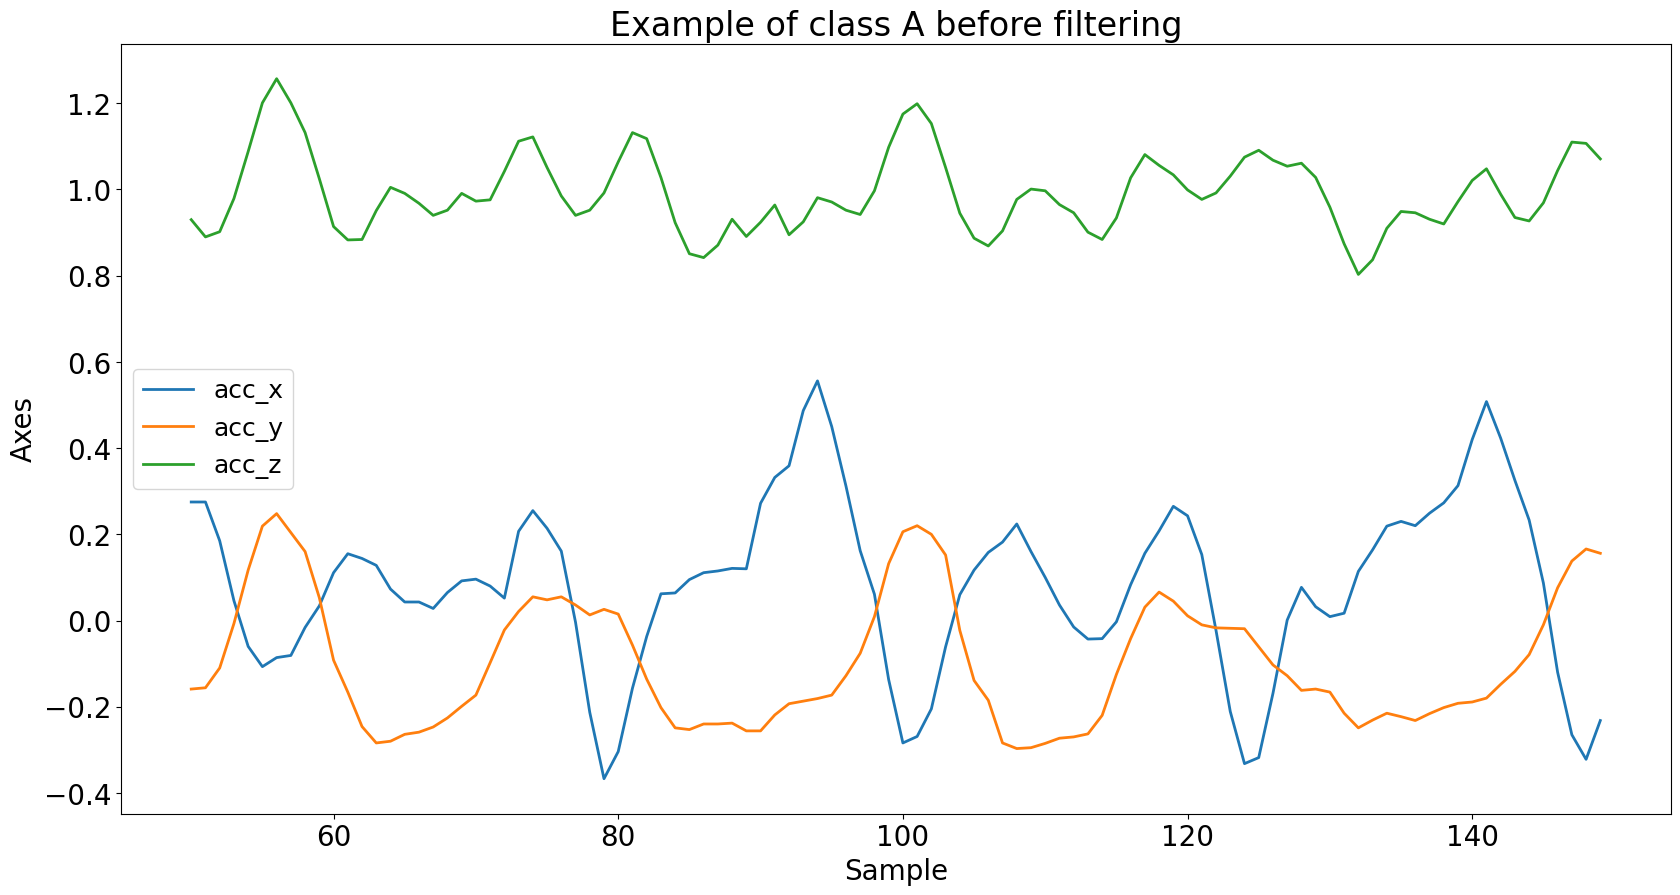

Filtering windows:   0%|          | 0/5 [00:00<?, ?it/s]

Number of filtered instances in the list: 48
Number of filtered instances in the list: 48
Number of filtered instances in the list: 48
Number of filtered instances in the list: 48
Number of filtered instances in the list: 48


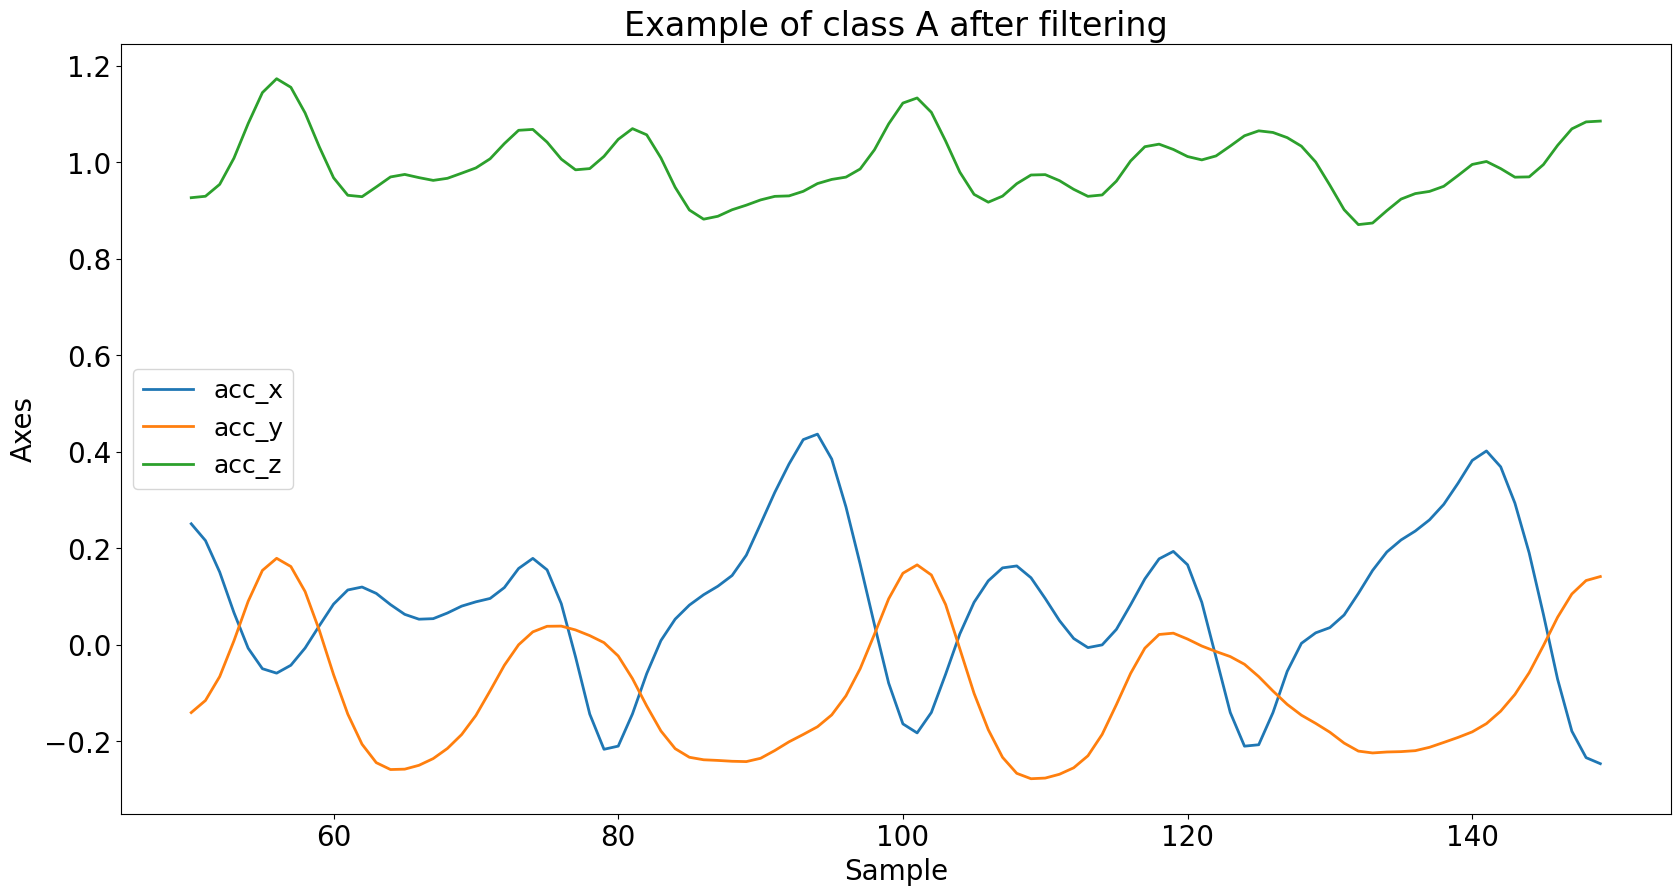

In [11]:
filtered_windows = {}

plot_instance_time_domain(all_windows['class_A'][config["x_number"]])
plt.title("Example of class A before filtering", fontsize=24)
plt.show()

# for each class, apply the filter to the windows with a progress bar
for class_name, windows in tqdm(all_windows.items(), desc="Filtering windows"):
    filtered_windows[class_name] = filter_instances(
        windows, 
        config["filter"]["order"], 
        config["filter"]["wn"], 
        config["filter"]["type"], 
    )

plot_instance_time_domain(filtered_windows['class_A'][config["x_number"]])
plt.title("Example of class A after filtering", fontsize=24)
plt.show()

As it seems in the above graphs, after the data passed through the low pass filter, the skewness of the data was highly reduced.

## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [12]:
all_numpy = {}

for class_name, instances_list in tqdm(filtered_windows.items(), desc="Converting to numpy"):
    instances_np = np.array([df.to_numpy() for df in instances_list])  # shape: (instances, time, axes)
    all_numpy[class_name] = instances_np
    print(f"{class_name} shape:", instances_np.shape)

Converting to numpy:   0%|          | 0/5 [00:00<?, ?it/s]

class_A shape: (48, 100, 3)
class_D shape: (48, 100, 3)
class_L shape: (48, 100, 3)
class_M shape: (48, 100, 3)
class_U shape: (48, 100, 3)


## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances

In [13]:
# Folder containing the train data
csv_folder = "train_data"
os.makedirs(csv_folder, exist_ok=True)

# Flatten and collect all instances and labels
flattened_all = []
for class_name, instances_list in tqdm(filtered_windows.items(), desc="Flattening instances"):
    df_flat = flatten_instances_df(instances_list)
    df_flat.insert(0, "Class", class_name)
    flattened_all.append(df_flat)

# Concatenate all class dataframes
df_all = pd.concat(flattened_all, ignore_index=True)

# Rename columns
num_features = df_all.shape[1] - 1
df_all.columns = ['Class'] + [f'Feature_{i+1}' for i in range(num_features)]

# Save to CSV
df_all.to_csv(os.path.join(csv_folder, 'flattened_data.csv'), index=False)

# Preview
print(df_all.head())

Flattening instances:   0%|          | 0/5 [00:00<?, ?it/s]

     Class  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0  class_A   0.010685  -0.004654   0.023952   0.025796  -0.011235   0.057825   
1  class_A   0.250410  -0.140821   0.926244   0.215634  -0.115733   0.929215   
2  class_A  -0.256737   0.199123   1.167338  -0.221287   0.186498   1.151531   
3  class_A   0.022800   0.078360   1.051560   0.069653   0.027656   1.025867   
4  class_A   0.170442  -0.155454   0.895676   0.155380  -0.179618   0.912323   

   Feature_7  Feature_8  Feature_9  ...  Feature_291  Feature_292  \
0   0.062277  -0.027124   0.139603  ...     0.964130     0.190358   
1   0.150317  -0.066192   0.953905  ...     1.034759    -0.179355   
2  -0.156459   0.153161   1.110897  ...     1.090271     0.088468   
3   0.115183  -0.040524   0.994266  ...     1.081462    -0.042185   
4   0.148711  -0.211335   0.934831  ...     0.987729     0.129503   

   Feature_293  Feature_294  Feature_295  Feature_296  Feature_297  \
0    -0.064139     0.974299     0.

## Train/Test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Split the data into features and labels
X = df_all.drop(columns=['Class'])  
y = df_all['Class']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

## Scaling

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import encode_labels

In [17]:
# Perform standard scaling on the features
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

# Encode the labels
y_train_encoded = encode_labels(y_train)
y_test_encoded = encode_labels(y_test)

## Transform to 2D again

In [18]:
window_length = 100 
n_axes = 3

# Convert to numpy array if it's a DataFrame
X_train_np = np.array(X_train_scaled)
X_test_np = np.array(X_test_scaled)

# Reshape the data so each window is 2d
X_train_2d = X_train_np.reshape(-1, window_length, n_axes)
X_test_2d = X_test_np.reshape(-1, window_length, n_axes)

print(X_train_2d.shape)
print(X_test_2d.shape)

(192, 100, 3)
(48, 100, 3)


## Dimensionality Reduction with PCA using the 1D (flattened) data

In [19]:
# add transformers
from sklearn.decomposition import PCA

In [20]:
# use the 1D data for PCA
data = X_train_scaled

# Initialize PCA with 2 components
pca2d = PCA(n_components=config["PCA"]["n_comp"][0])


### PCA with 2 Components

In [21]:
# Compute the principal components
pca_object = pca2d.fit(data)

In [22]:
# Project the data onto the principal components
X_train_pca = pca2d.transform(data)
X_test_pca = pca2d.transform(X_test_scaled)

print("Transformed train shape:", X_train_pca.shape)
print("Transformed test shape:", X_test_pca.shape)

Transformed train shape: (192, 2)
Transformed test shape: (48, 2)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Principal component', ylabel='Explained variance (fraction) per component'>)

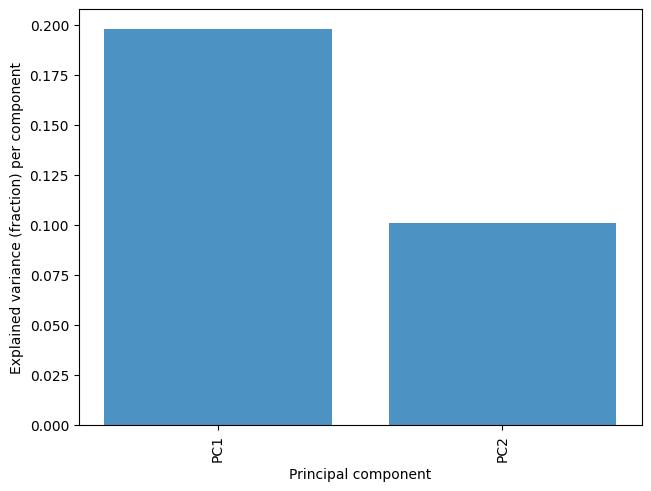

In [23]:
# Plot the variances of the principal components
pca_explained_variance_bar(pca_object, alpha=0.8)

The first principal component explains double the variance of the dataset compared to the second principal component.

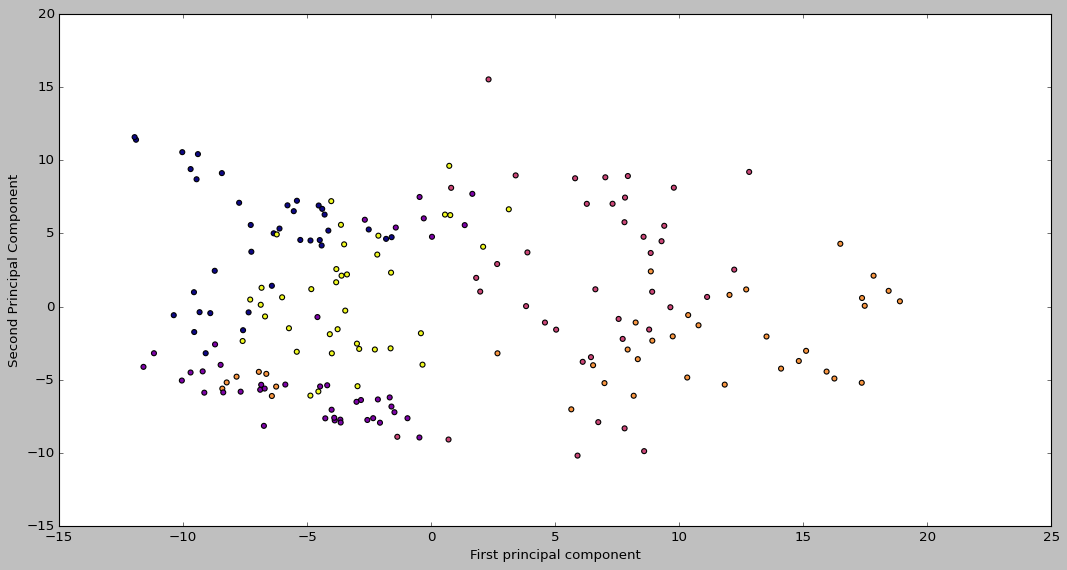

In [24]:
# Store the PCA transformed data in a DataFrame
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

# Add the label column
X_train_pca_df['Label'] = y_train_encoded

# Make a scatter plot for the trnsformed data
plot_scatter_pca(X_train_pca_df, c_name='Label')


The data is more spread on the axis of the first principal component.

### PCA with 3 Components

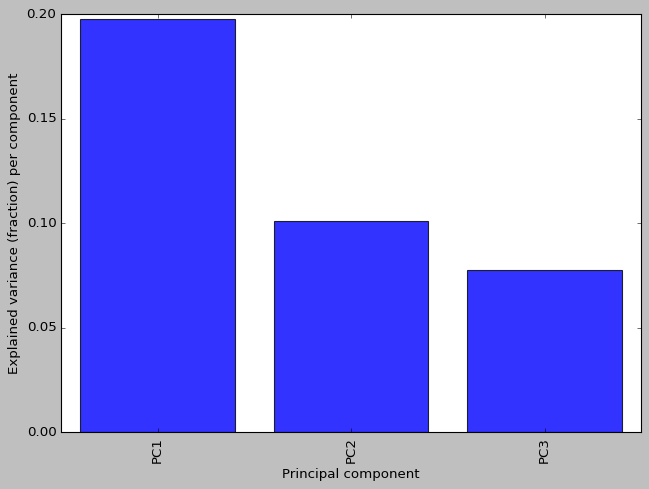

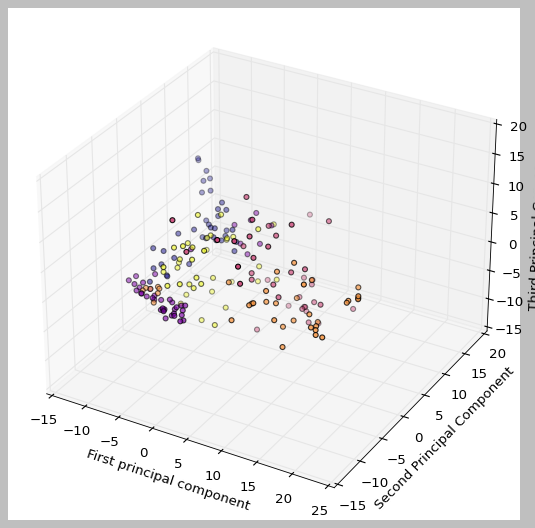

In [25]:
# Initialize PCA with 3 components
pca3d = PCA(n_components=config["PCA"]["n_comp"][1])

# Compute the principal components
pca_object = pca3d.fit(data)

# Project the data onto the principal components
X_train_pca = pca3d.transform(data)
X_test_pca = pca3d.transform(X_test_scaled)

# Plot the variances of the principal components
pca_explained_variance_bar(pca_object, alpha=0.8)

# Store the PCA transformed data in a DataFrame
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

# Add the label column
X_train_pca_df['Label'] = y_train_encoded

# Make a scatter plot for the trnsformed data
plot_scatter_pca(X_train_pca_df, c_name='Label')

The second and third principal components seem to explain almost the same level of variance of the dataset. About half of the variance the first principal component explains.

### PCA with X% of the variance of the dataset, for training the statistical AI Models

The DataFrame has more than 4 columns.


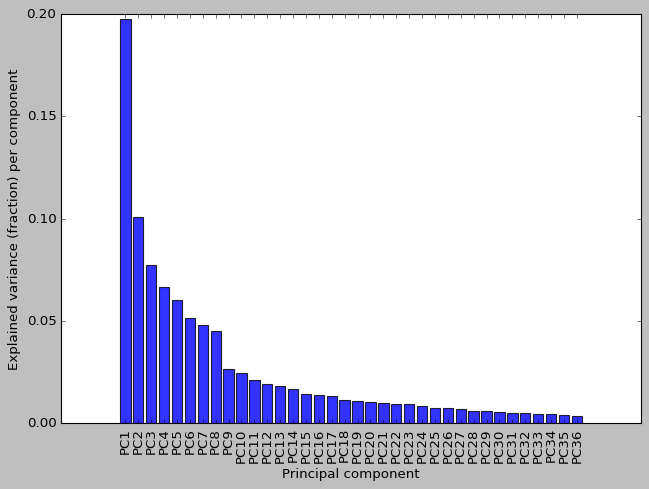

In [26]:
# Initialize PCA with variance 95%
pca_var = PCA(n_components=config["PCA"]["variance"])

# Compute the principal components
pca_var.fit(X_train_scaled)

# Project the data onto the principal components
X_train_pca_var = pca_var.transform(X_train_scaled)
X_test_pca_var = pca_var.transform(X_test_scaled)

# Plot explained variance
pca_explained_variance_bar(pca_var, alpha=0.8)

# Put into DataFrame and add labels for plotting if you want (like before)
X_train_pca_var_df = pd.DataFrame(
    X_train_pca_var, 
    columns=[f'PC{i+1}' for i in range(X_train_pca_var.shape[1])]
)
X_train_pca_var_df['Label'] = y_train_encoded

# Plot scatter with selected PCs (e.g., first 2 or 3)
plot_scatter_pca(X_train_pca_var_df, c_name='Label')


To explain 95% of the variance of the dataset we need 36 principal components.

## Classifier - Statistical Learning

### Apply simple classifier

In [27]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [28]:
# Initialize Support Vector Machine Model
svc_model = SVC(
    C=config["classifier"]["SVC"]["C"],
    kernel=config["classifier"]["SVC"]["kernel"],
    gamma=config["classifier"]["SVC"]["gamma"],
    max_iter=config["classifier"]["SVC"]["max_iter"]
)

# Train the SVC model
svc_model.fit(X_train_pca_var, y_train_encoded)

SVC(C=0.01, kernel='linear')

In [29]:
# Initialize Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=config["classifier"]["RandomForest"]["n_estimators"],
    n_jobs=config["classifier"]["RandomForest"]["n_jobs"],
    random_state=config["classifier"]["RandomForest"]["random_state"]
)

# Train the Random Forest model
rf_model.fit(X_train_pca_var, y_train_encoded)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

### Evaluate simple classifier

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
from sklearn.metrics import classification_report

SVC Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.62      0.83      0.71         6
           2       0.75      0.67      0.71         9
           3       0.67      0.73      0.70        11
           4       0.88      0.70      0.78        10

    accuracy                           0.79        48
   macro avg       0.78      0.79      0.78        48
weighted avg       0.80      0.79      0.79        48

SVC Confusion Matrix:


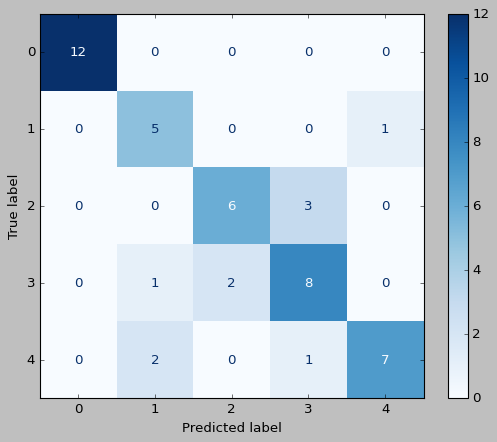

In [32]:
# Predict with SVC
y_pred_svc = svc_model.predict(X_test_pca_var)

# Compute the classification report
print("SVC Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_svc))

# Compute and display the confusion matrix for SVC
print("SVC Confusion Matrix:")
svc_matrix = confusion_matrix(y_test_encoded, y_pred_svc)
svc_display = ConfusionMatrixDisplay(confusion_matrix=svc_matrix)
svc_display.plot(cmap="Blues")

The confusion matrix is more dominant on the diagonal. Explains why the classification is quite accurate.

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.71      0.83      0.77         6
           2       0.78      0.78      0.78         9
           3       0.64      0.82      0.72        11
           4       1.00      0.50      0.67        10

    accuracy                           0.77        48
   macro avg       0.80      0.77      0.76        48
weighted avg       0.80      0.77      0.77        48

Random Forest Confusion Matrix:


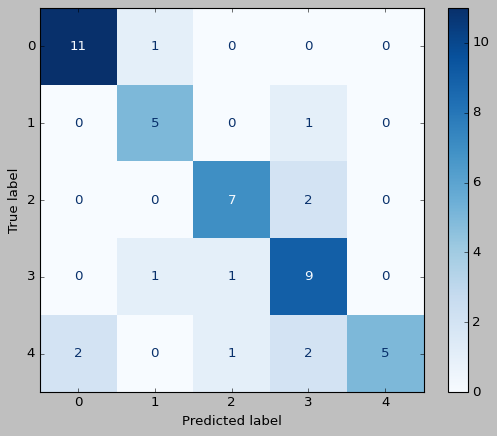

In [33]:
# Predict with Random Forest
y_pred_rf = rf_model.predict(X_test_pca_var)

# Compute the classification report for Random Forest
print("Random Forest Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_rf))

# Compute and display the confusion matrix for Random Forest
print("Random Forest Confusion Matrix:")
rf_matrix = confusion_matrix(y_test_encoded, y_pred_rf)
rf_display = ConfusionMatrixDisplay(confusion_matrix=rf_matrix)
rf_display.plot(cmap="Blues")

The confusion matrix is more dominant on the diagonal. The accuracy of the Random Forest is close to that of the SVM.

### Apply optimization with Grid Search and Cross-validation

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [35]:
# Set up GridSearchCV for SVC
grid_search_svc = GridSearchCV(
    estimator=SVC(),
    param_grid=config['fine_tune_svc']['param_grid'],
    cv=config['fine_tune_svc']['cv'],
    verbose=config['fine_tune_svc']['verbose'],
    scoring=config['fine_tune_svc']['scoring'],
    n_jobs=config['fine_tune_svc']['n_jobs']
)

# Find the best parameters
grid_search_svc.fit(X_train_pca_var, y_train_encoded)

# Make the best model
best_svc_model = grid_search_svc.best_estimator_

# Train the best SVC model
best_svc_model.fit(X_train_pca_var, y_train_encoded)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


SVC(C=10, gamma=0.001)

In [36]:
# Set up GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=config['fine_tune_rf']['param_grid'],
    cv=config['fine_tune_rf']['cv'],
    verbose=config['fine_tune_rf']['verbose'],
    scoring=config['fine_tune_rf']['scoring'],
    n_jobs=config['fine_tune_rf']['n_jobs']
)

# Find the best parameters
grid_search_rf.fit(X_train_pca_var, y_train_encoded)

# Make the best model
best_rf_model = grid_search_rf.best_estimator_

# Train the best Random Forest model
best_rf_model.fit(X_train_pca_var, y_train_encoded)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_features='log2', n_estimators=150)

### Evaluate optimized classifier

SVC Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.55      1.00      0.71         6
           2       1.00      0.89      0.94         9
           3       0.90      0.82      0.86        11
           4       0.88      0.70      0.78        10

    accuracy                           0.85        48
   macro avg       0.86      0.86      0.85        48
weighted avg       0.89      0.85      0.86        48

SVC Confusion Matrix:


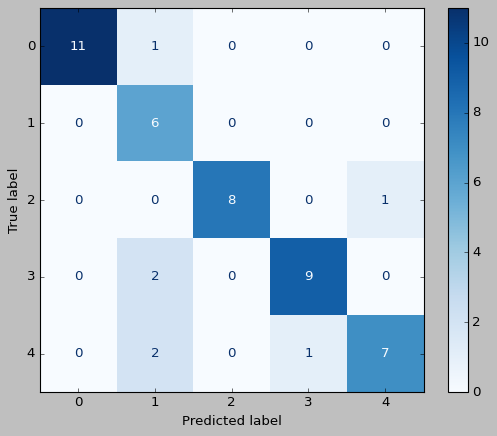

In [37]:
# Predict with SVC
y_pred_svc = best_svc_model.predict(X_test_pca_var)

# Compute the classification report
print("SVC Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_svc))

# Compute and display the confusion matrix for SVC
print("SVC Confusion Matrix:")
svc_matrix = confusion_matrix(y_test_encoded, y_pred_svc)
svc_display = ConfusionMatrixDisplay(confusion_matrix=svc_matrix)
svc_display.plot(cmap="Blues")

Since the dataset has balanced classes, the grid search was based on accuracy score and therefore improves it. It also improves almost all of the other evaluation metrics.

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.83      0.83      0.83         6
           2       0.90      1.00      0.95         9
           3       0.83      0.91      0.87        11
           4       1.00      0.70      0.82        10

    accuracy                           0.90        48
   macro avg       0.90      0.89      0.89        48
weighted avg       0.90      0.90      0.89        48

Random Forest Confusion Matrix:


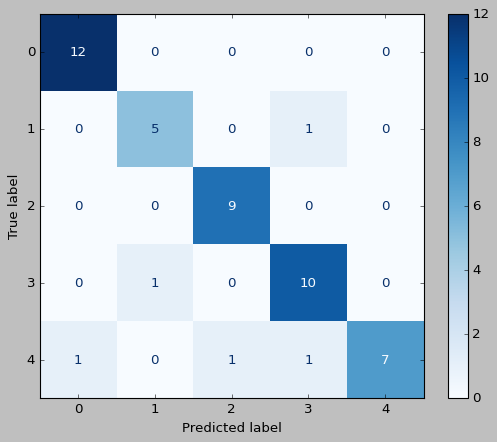

In [38]:
# Predict with Random Forest
y_pred_rf = best_rf_model.predict(X_test_pca_var)

# Compute the classification report for Random Forest
print("Random Forest Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_rf))

# Compute and display the confusion matrix for Random Forest
print("Random Forest Confusion Matrix:")
rf_matrix = confusion_matrix(y_test_encoded, y_pred_rf)
rf_display = ConfusionMatrixDisplay(confusion_matrix=rf_matrix)
rf_display.plot(cmap="Blues")

The grid seacrh on the Random Forest had similar effects on the Random Forest too. It even reaches 90% accuracy.

## Classifier - Neural Network

In [58]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [59]:
input_data_shape = X_train_2d[0].shape
print("Type of the input shape object:", type(input_data_shape))
X_train_2d[0].shape

Type of the input shape object: <class 'tuple'>


(100, 3)

In [60]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

Number of outputs (classes) the model to predict: 5


### Create the Neural Network (NN) Architecture and instantiate the model

Since the data we are handling is a multidimensional time series, a CNN is a good choice. 4 layers are used to capture complex patterns. The rest of the parameters are chosen through trial and error.

In [159]:
# Instanciate a sequential model
model = Sequential()

# 1st Convolution Block (for simple patterns)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# 2nd Convolution Block (for complex patterns)
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# 3rd Convolution Block (for more complex patterns)
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# 4th Convolution Block (for more complex patterns)
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(n_outputs, activation='softmax'))


Plot the Architecture of ot the TensorFlow model

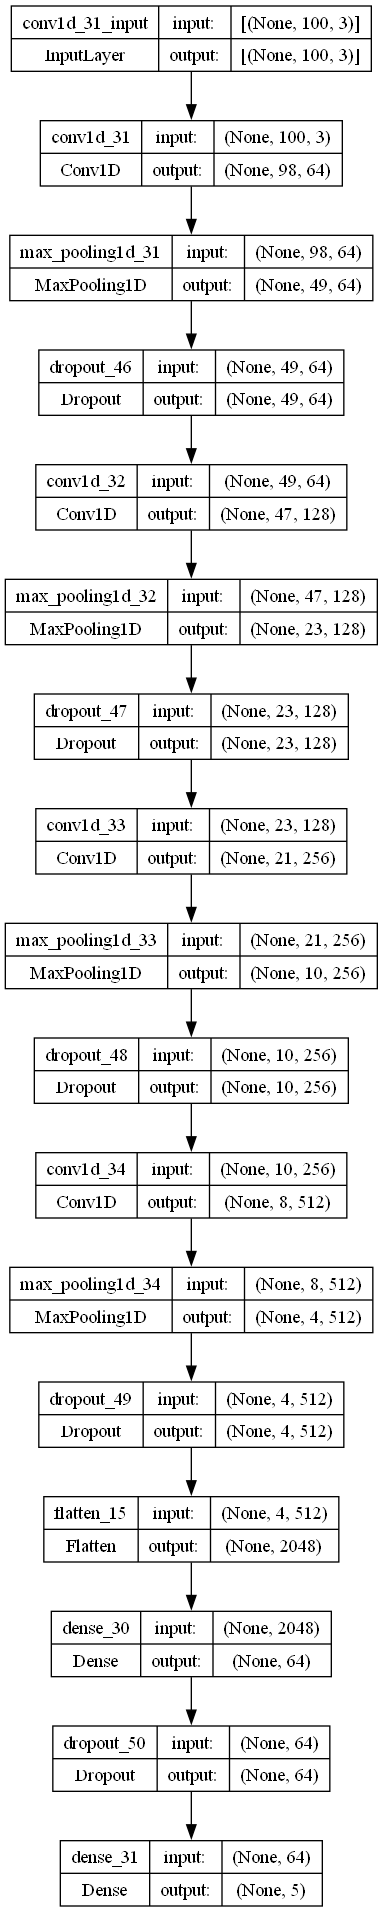

In [160]:
from keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='architecture.png', show_shapes=True, show_layer_names=True)

Plot the summary of the TensorFlow model

In [161]:
# Plot the summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 98, 64)            640       
                                                                 
 max_pooling1d_31 (MaxPooli  (None, 49, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_46 (Dropout)        (None, 49, 64)            0         
                                                                 
 conv1d_32 (Conv1D)          (None, 47, 128)           24704     
                                                                 
 max_pooling1d_32 (MaxPooli  (None, 23, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_47 (Dropout)        (None, 23, 128)         

### Build the NN model

Accuracy metric is being used since the classes are balanced.

In [162]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [163]:
from utils import encode_labels

In [164]:
# Encode the labels
y_encoded = encode_labels(y)

# Then split training data into training and validation
X_train_2d_final, X_val_2d, y_train_encoded_final, y_val_encoded = train_test_split(
    X_train_2d, y_train_encoded,
    test_size=0.1,
    random_state=42,
    stratify=y_train_encoded
)

### Train the NN model

In [165]:
# Train the model
start_time = datetime.now()
training = model.fit(
    X_train_2d_final, y_train_encoded_final,
    epochs=config['fit']['epochs'],
    batch_size=config['fit']['batch'],
    verbose=config['fit']['verbose'],
    validation_data=(X_val_2d, y_val_encoded)
)
end_time = datetime.now()
print(f"Training completed in: {end_time - start_time}")

Epoch 1/100
11/11 [==============================] - 2s 59ms/step - loss: 1.6113 - accuracy: 0.2558 - val_loss: 1.4436 - val_accuracy: 0.4000
Epoch 2/100
11/11 [==============================] - 0s 29ms/step - loss: 1.1767 - accuracy: 0.5058 - val_loss: 1.2296 - val_accuracy: 0.5500
Epoch 3/100
11/11 [==============================] - 0s 33ms/step - loss: 1.0079 - accuracy: 0.5872 - val_loss: 1.0766 - val_accuracy: 0.5000
Epoch 4/100
11/11 [==============================] - 0s 31ms/step - loss: 0.8270 - accuracy: 0.7093 - val_loss: 1.0438 - val_accuracy: 0.6500
Epoch 5/100
11/11 [==============================] - 0s 32ms/step - loss: 0.6212 - accuracy: 0.7791 - val_loss: 0.6550 - val_accuracy: 0.8000
Epoch 6/100
11/11 [==============================] - 0s 30ms/step - loss: 0.4584 - accuracy: 0.8372 - val_loss: 0.6218 - val_accuracy: 0.7500
Epoch 7/100
11/11 [==============================] - 0s 28ms/step - loss: 0.4948 - accuracy: 0.8314 - val_loss: 0.6697 - val_accuracy: 0.7000
Epoch 

### Evaluate the model on the test data

2/2 [==============================] - 0s 8ms/step
CNN Classification Report:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.67      1.00      0.80         6
           2       1.00      0.78      0.88         9
           3       0.90      0.82      0.86        11
           4       0.89      0.80      0.84        10

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.87        48
weighted avg       0.89      0.88      0.88        48

CNN Confusion Matrix:


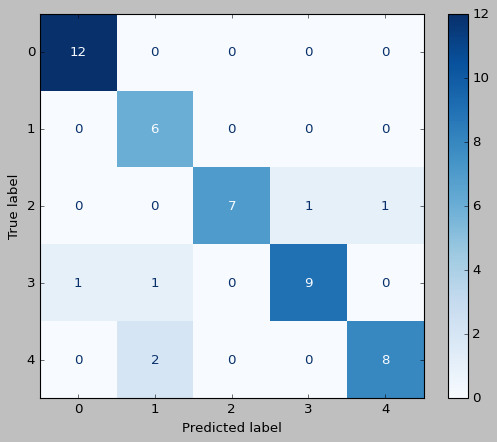

In [166]:
# Predict with CNN
y_pred_cnn_probs = model.predict(X_test_2d)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

# Compute the classification report for CNN
print("CNN Classification Report:\n")
print(classification_report(y_test_encoded, y_pred_cnn))

# Compute and display the confusion matrix for CNN
print("CNN Confusion Matrix:")
cnn_matrix = confusion_matrix(y_test_encoded, y_pred_cnn)
cnn_display = ConfusionMatrixDisplay(confusion_matrix=cnn_matrix)
cnn_display.plot(cmap="Blues")

The matrix has a dominant diagonal which means that the classification tends to be accurate.

### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets

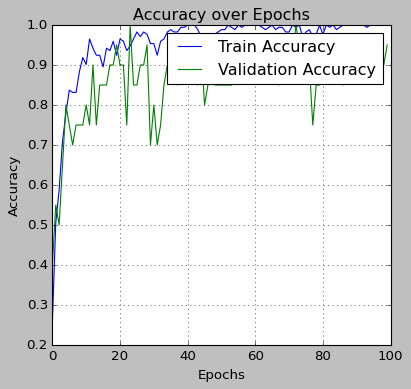

In [167]:
# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training.history['accuracy'], label='Train Accuracy')
plt.plot(training.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

The train accuracy increases rapidly in the first 15 epochs and then then plateaus. It follows some sort of skewed logarithmic curve. The same thing happens with the validation accuracy, but after the rapid increase, it becomes unpredictable, pointing to possible overfitting.

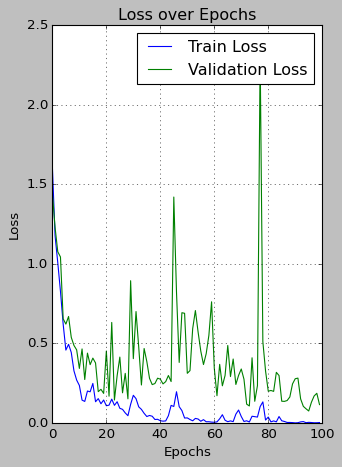

In [168]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(training.history['loss'], label='Train Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

A similar thing happens to the loss curve. The train loss drops rapidly in the first 15 epochs and then plateaus in a skewed manner, indicating that the model learns. Te validation loss curve, after a sudden drop in the first 15 epochs, starts to increase and decrease chaotically. An indicator of overfitting.